# Test Systems

Uses REBOUND commit 25f856dc2f79e0ad17b2f6bd604225f550593376

Test trained models on real non-resonant systems

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
import itertools
from collections import OrderedDict
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech import Andoyer, AndoyerHamiltonian
from celmech.resonances import resonant_period_ratios, resonance_intersections_list, resonance_pratio_span
from celmech.transformations import masses_to_jacobi

warnings.filterwarnings('ignore')
plt.style.use('paper')
%matplotlib inline

In [2]:
if rebound.__githash__ != '25f856dc2f79e0ad17b2f6bd604225f550593376':
    print('Should checkout commit above to ensure this runs correctly')

Should checkout commit above to ensure this runs correctly


In [3]:
system = 'nonressystems/Kepler-446/'
datarepopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/'

In [4]:
def systeminfo(system):
    sapath = datarepopath + 'data/' + system + 'simulation_archives/runs/'
    sa = rebound.SimulationArchive(sapath+'sa0000001.bin')
    sim = sa[0]
    
    ps = sim.particles
    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3./ps[0].m)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3./ps[0].m)**(1./3.)
    beta12 = (ps[2].a-ps[1].a)/Rhill12
    beta23 = (ps[3].a-ps[2].a)/Rhill23
    P12 = ps[2].P/ps[1].P
    P23 = ps[3].P/ps[2].P
    print("P2/P1 = {0}\nP3/P2 = {1}\na2-a1 = {2} RH_12\na3-a2 = {3} RH_23".format(P12, P23, beta12, beta23))
    fig = rebound.OrbitPlot(sim)

P2/P1 = 1.9395046625940953
P3/P2 = 1.6958321133757708
a2-a1 = 17.830745989332478 RH_12
a3-a2 = 14.929810416733591 RH_23


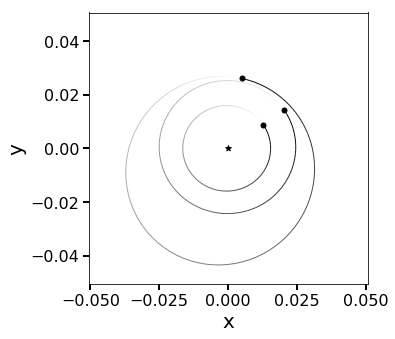

In [5]:
systeminfo(system)

In [35]:
def findres2(sim, i1, i2):
    delta = 0.03
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[i1].M
    m2 = ps[i2].m/ps[i2].M

    Pratio = n2/n1
    if np.isnan(Pratio): # probably due to close encounter where averaging step doesn't converge 
        return np.nan, np.nan, np.nan

    res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=maxorder)

    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)

    maxstrength = 0
    j, k, i1, i2, strength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*Z**((b-a)/2.)/((b*n2 - a*n1)/n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            
            strength=s
            maxstrength = s

    return j, k, strength

def get_k(row, system):
    sapath = datarepopath + 'data/' + system + 'simulation_archives/runs/'
    sa = rebound.SimulationArchive(sapath+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    
    N = sim.N
    ps = sim.particles
    
    maxstrength = 0.
    strengthi = [0,0]
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        j, k, strength = findres2(sim, i1, i2)
        if strength > maxstrength:
            maxi1 = i1
            maxi2 = i2
            maxj = j
            maxk = k
            maxstrength = strength
    
    pvars = Poincare.from_Simulation(sim)
    avars = Andoyer.from_Poincare(pvars, j=maxj, k=maxk, a10 = ps[1].a, i1=maxi1, i2=maxi2)
    row['Z'] = avars.Z
    row['Zx'] = avars.Z*np.cos(avars.phi)
    row['Zy'] = avars.Z*np.sin(avars.phi)
    row['Zcom'] = avars.Zcom
    row['Zcomx'] = avars.Zcom*np.cos(avars.phiZcom)
    row['Zcomy'] = avars.Zcom*np.sin(avars.phiZcom)

    return row

In [49]:
modelfile = 'ressummaryfeaturesxgb_resonantScaleFree.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

systems = ttvsystems()

ID=-2
system = systems[ID]
print(system)
trainpath = repopath+'training_data/' + system + featurefolder
    
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
labels.head()

TTVsystems/KOI-2086/


,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,9.990000e+08,9.990000e+08,True
1,0000001.bin,1.000000e+09,1.000000e+09,True
2,0000002.bin,9.990000e+08,9.990000e+08,True
3,0000003.bin,1.000000e+09,1.000000e+09,True
4,0000004.bin,1.000000e+09,1.000000e+09,True


In [50]:
get_k(labels.loc[18], system)

runstring                  0000018.bin
instability_time                 1e+09
shadow_instability_time          1e+09
Stable                            True
h                            0.0438171
k                           -0.0146005
Z                            0.0265317
Zx                          -0.0264841
Zy                         -0.00158902
Zcom                         0.0360291
Zcomx                      -0.00478439
Zcomy                        0.0357101
Name: 18, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

(array([  2.,   3.,   3.,   3.,   3.,   3.,   4., 501.,   4., 974.]),
 array([5.34359913, 5.70923922, 6.07487931, 6.44051939, 6.80615948,
        7.17179957, 7.53743965, 7.90307974, 8.26871983, 8.63435991,
        9.        ]),
 <a list of 10 Patch objects>)

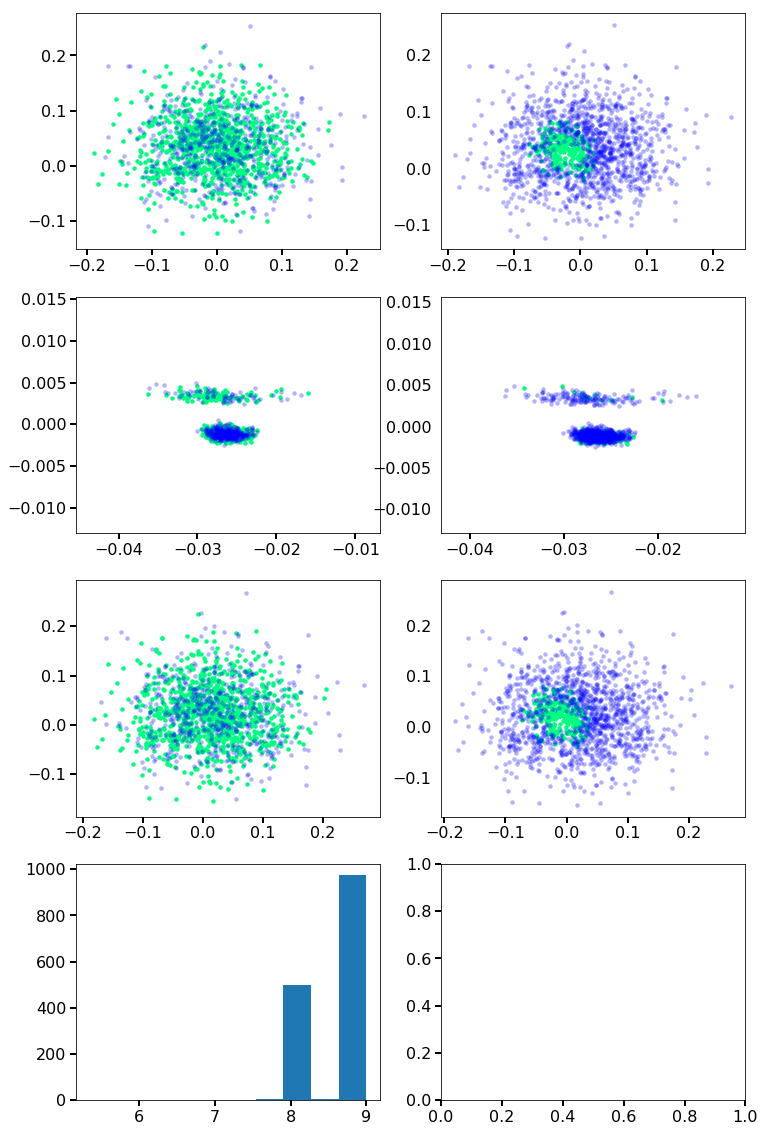

In [51]:
trainpath = repopath+'training_data/' + system + featurefolder
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
dasklabels = dd.from_pandas(labels, npartitions=24)
testres = get_k(labels.loc[18], system)
dasklabels = dasklabels.apply(get_k, system=system, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

# Make predictions on the simulations using passed model
tdata = pd.read_csv(trainpath + 'trainingdata.csv', index_col=0)
if features is None:
    features = tdata.columns.values
tdata = tdata[features]
proba = model.predict_proba(tdata[features])[:,1]

stablemask = dasklabels['Stable'] == True
unstablemask = dasklabels['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
s=20

fig, axarr = plt.subplots(figsize = (12,20), ncols=2, nrows=4)
axarr[0, 0].scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0, 0].scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0, 1].scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0, 1].scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0, 1].tick_params(axis='y', which='both', left='off', right='off')

axarr[1, 0].scatter(dasklabels["Zx"][stablemask], dasklabels["Zy"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1, 0].scatter(dasklabels["Zx"][unstablemask], dasklabels["Zy"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1, 1].scatter(dasklabels["Zx"][pstablemask], dasklabels["Zy"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1, 1].scatter(dasklabels["Zx"][punstablemask], dasklabels["Zy"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1, 1].tick_params(axis='y', which='both', left='off', right='off')

axarr[2, 0].scatter(dasklabels["Zcomx"][stablemask], dasklabels["Zcomy"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[2, 0].scatter(dasklabels["Zcomx"][unstablemask], dasklabels["Zcomy"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[2, 1].scatter(dasklabels["Zcomx"][pstablemask], dasklabels["Zcomy"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[2, 1].scatter(dasklabels["Zcomx"][punstablemask], dasklabels["Zcomy"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[2, 1].tick_params(axis='y', which='both', left='off', right='off')

axarr[3,0].hist(np.log10(labels['instability_time']))

In [45]:
def plot_system(system, model, features, featurefolder, threshold, ax1, ax2):
    trainpath = repopath+'training_data/' + system + featurefolder
    labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
    # Create k and h columns for plotting
    labels['k'] = 0.
    labels['h'] = 0.
    dasklabels = dd.from_pandas(labels, npartitions=24)
    dasklabels = dasklabels.apply(get_k, system=system, axis=1, meta=labels).compute(scheduler='processes')
    
    # Make predictions on the simulations using passed model
    tdata = pd.read_csv(trainpath + 'trainingdata.csv', index_col=0)
    if features is None:
        features = tdata.columns.values
    tdata = tdata[features]
    proba = model.predict_proba(tdata[features])[:,1]
    
    stablemask = dasklabels['Stable'] == True
    unstablemask = dasklabels['Stable'] == False
    pstablemask = proba > threshold
    punstablemask = proba < threshold

    colorbar = 'winter'
    cmap = matplotlib.cm.get_cmap(colorbar)
    s=20
    
    ax1.scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
    ax1.scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
    ax2.scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
    ax2.scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)

    ax2.tick_params(axis='y', which='both', left='off', right='off')
    ax1.text(-0.25, 0.3, system.split('/')[1], weight='bold', size=24, color='red')

In [46]:
def ttvsystems():
    folders = ['KOI-0115', 'KOI-0168', 'KOI-0085', 'KOI-0156', 'KOI-1576', 'KOI-2086', 'KOI-0314']
    return ['TTVsystems/' + folder + '/' for folder in folders]

def nonressystems():
    folders = ['Kepler-431', 'EPIC-210897587-2', 'Kepler-446', 'LP-358-499']
    return ['nonressystems/' + folder + '/' for folder in folders]

In [47]:
def plotsystems(systems, model, features, featurefolder, threshold, modelfile):
    Nsystems = len(systems)
    Nrows = int(np.ceil(Nsystems/2)) # 2 systems per row 
    # 2 systems per row* 2 panels (Nbody, XGboost) = 4 columns
    f, axarr = plt.subplots(Nrows,4, figsize=[16, 4*Nrows], sharex=True, sharey=True)

    for i, system in enumerate(systems):
        row1 = 2*i//4
        col1 = 2*i%4
        row2 = (2*i+1)//4
        col2 = (2*i+1)%4
        plot_system(system, model, features, featurefolder, threshold, axarr[row1,col1], axarr[row2,col2])
        
    scale = 0.4
    for ax in axarr.flat:
        ax.set_ylim([-scale, scale])
        ax.set_xlim([-scale, scale])

    for ax in axarr[:,0]: # ylabel on first column
        ax.set_ylabel(r'$e_y$') 
    for ax in axarr[1,:]: # xlabel on bottom row
        ax.set_xlabel(r'$e_x$') 

    axarr[0,0].set_title("Nbody")
    axarr[0,1].set_title("ML model")
    axarr[0,2].set_title("Nbody")
    axarr[0,3].set_title("ML model")
    axarr[0,0].legend(loc='lower left')
    
    axarr[Nrows//2, 1].set_title(modelfile, fontsize=24)
    axarr[Nrows//2, -1].set_title('thresh={0}'.format(threshold), fontsize=24)
    plt.subplots_adjust(wspace=0)
    plt.savefig(modelfile+"NbodyvsML"+systems[0].split('/')[0]+".png", bbox_inches="tight")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

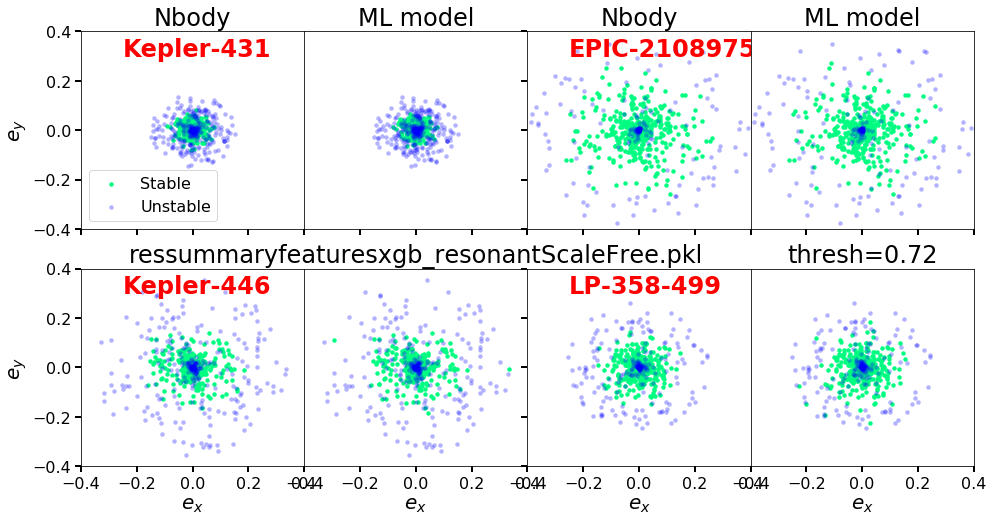

In [11]:
modelfile = 'ressummaryfeaturesxgb_resonantScaleFree.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.69
systems = nonressystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

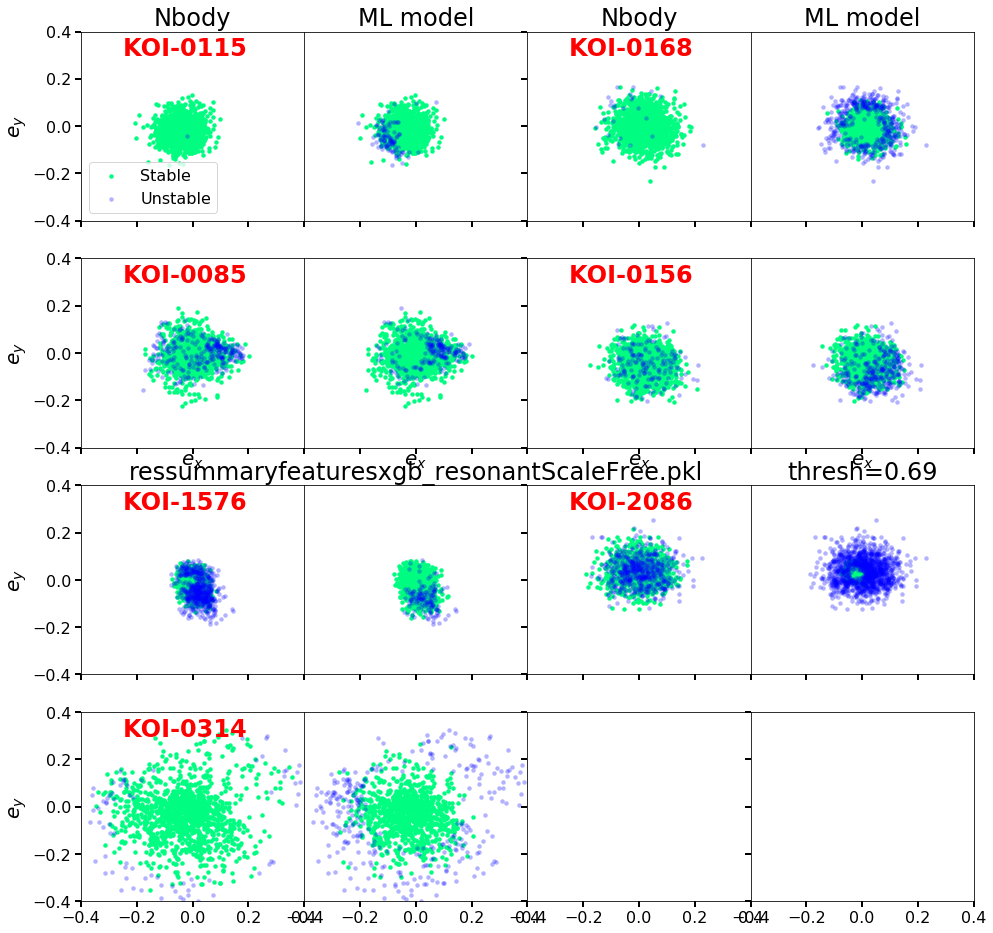

In [12]:
modelfile = 'ressummaryfeaturesxgb_resonantScaleFree.pkl'
repopath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/'
model, features, featurefolder = pickle.load(open(repopath+"models/"+modelfile, 'rb'))

threshold = 0.69
systems = ttvsystems()
plotsystems(systems, model, features, featurefolder, threshold, modelfile)